<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.975 · Deep Learning · PAC1</p>
<p style="margin: 0; text-align:right;">2024-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia y Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC 1: Xarxes neuronals artificials i convolucionals amb Keras - Classificació d’imatges i superresolució

Al llarg d'aquesta pràctica, implementarem diversos models de xarxes neuronals, utilitzant Keras i la base de dades Imagenette (versió 320px). Concretament, abordarem les tasques següents:
1. Descàrrega, anàlisi i pre-processament de les dades (1,5 pts)
2. Xarxa neuronal artificial (ANN) completament connectada (1,5 pts)
3. Petita xarxa neuronal convolucional (CNN) (2 pts)
4. Augmentació de dades (1 pt)
5. Superresolució d’imatges amb CNNs (1,5 pts)
6. Inferència, mètriques i visualització dels resultats (1 pt)
7. Model Pre-entrenat en Superresolució (1 pt)
8. Comparació i conclusions (0,5 pts)

<u> Consideracions generals </u>:

- La solució proposada no pot utilitzar mètodes, funcions o paràmetres declarats **_deprecated_** en versions futures.
- Aquest PAC s’ha de fer d’una manera **estrictament individual**. Qualsevol indici de còpia serà penalitzat amb un suspens (D) per a totes les parts implicades i la possible avaluació negativa de la totalitat de l'assignatura.
- Cal que l'estudiant indiqui **totes les fonts** que ha utilitzat per a la realització del PEC. En cas contrari, es considerarà que l’alumne ha comès el plagi, sent penalitzat amb un suspens (D) i la possible avaluació negativa de la totalitat de l'assignatura.
- Si s’utilitza qualsevol **IA generativa** en la resolució de la PAC **s’ha de referenciar** en aquelles seccions on s’ha utilitzat, com qualsevol altra font.

<u>Format del lliurament </u>:

- Alguns exercicis poden suposar diversos minuts d’execució, de manera que el lliurament s’ha de fer en format **Notebook** i en el format **html**, on es vegi el codi, els resultats i els comentaris de cada exercici. Podeu exportar el quadern a HTML a Jupyter Notebook des del menú File $\to$ Download as $\to$ HTML.
- Hi ha un tipus especial de cel·la per allotjar el text. Aquest tipus de cel·les serà molt útil per respondre a les diferents preguntes teòriques plantejades al llarg de l’activitat. Per canviar el tipus de cel·la a aquest tipus, al menú: Cell $\to$ Cell Type $\to$ Markdown.

## 0. Context i càrrega de llibreries
Al llarg d’aquesta pràctica, implementarem diversos models de xarxes neuronals per classificar les imatges de la base de dades [Imagenette](https://github.com/fastai/imagenette).

La base de dades Imagenette és un subconjunt de 10 classes fàcilment classificables de [Imagenet](https://www.image-net.org/), un projecte fonamental per avançar en la investigació sobre visió artificial i aprenentatge profund. Imagenette conté unes 13.000 imatges de diferents mides pertanyents a 10 categories (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute), cadascuna en una carpeta diferent.

Concretament en aquesta PAC, utilitzarem una versió (Imagenette2-320) que ha estat re-escalada, però mantenint la relació d’aspecte de cada imatge (s’han ajustat de manera que la dimensió menor de cada imatge sigui de 320 píxels). Això atenuarà la càrrega computacional dels algoritmes quan s’utilitzen bases de dades d’imatges, però mantenint una qualitat suficient necessària per als nostres experiments. Les dades venen separades en 2 conjunts, entrenament i validació.

**Nota: A causa de l’ús d’imatges com dades d’aquesta pràctica, l’entrenament de cada exercici es pot retardar entre uns minuts i més de mitja hora mitjançant GPU (els temps utilitzant CPU són significativament més llargs). Es recomana realitzar la pràctica en l’entorn que ofereix la plataforma Kaggle, ja que ofereix un entorn gratuït amb 30 hores setmanals per a l’ús de la GPU.**

Al llarg de tota la pràctica, per a la creació de les diferents xarxes, alternem l’ús del model [Sequential](https://keras.io/guides/sequential_model/) i el model [Functional](https://keras.io/guides/functional_api/) de Keras a través de les seves classes [Sequential](https://keras.io/api/models/sequential/) i [Model](https://keras.io/api/models/model/) respectivament.

Es recomana la lectura detallada de la documentació dels dos models per dur a terme la realització de la pràctica.

Comencem per instal·lar i carregar les llibreries més rellevants:

In [1]:
# Instal·lem la darrera versió de Tensorflow (amb CUDA)
%pip install tensorflow[and-cuda]

In [2]:
# Importem Tensorflow
import tensorflow as tf
print("TensorFlow version   : ", tf.__version__)

# Necessitarem GPU
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# Keras versió is 3.5.0
from tensorflow import keras
print("Keras version   : ", keras.__version__)

TensorFlow version   :  2.17.1
GPU is available
Keras version   :  3.5.0


In [3]:
# Importem els elements de Keras que utilitzarem amb més freqüència
from keras.utils import image_dataset_from_directory
from keras.layers import (Input, Dense, Dropout, Flatten, Conv2D, Conv2DTranspose,
                          MaxPooling2D, UpSampling2D, Rescaling, Resizing,
                          RandomFlip, RandomRotation)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

In [4]:
# Importem algunes llibreries que necessitarem per a la PAC
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## 1. Descàrrega, anàlisi i dades pre-processades (1,5 punts)

En aquesta secció explorarem la base de dades i prepararem la càrrega de les imatges per als models de les seccions següents.

Per crear la nostra base de dades, hem de descarregar el fitxer d’imatges del següent [enllaç](https://drive.google.com/file/d/16kqYxjXK0xDDYQ4xF3PBgsa0NG3gwT4L/view?usp=sharing) (és un fitxer .zip que ocupa aproximadament 340 Mb).

**Nota: per descarregar el fitxer d'imatges, heu de iniciar la sessió amb l'usuari i la contrasenya de la UOC.**

A partir d’aquí:

- Si treballem en local, simplement hem de descomprimir el fitxer descarregat.

- Si treballem des de Kaggle hem de pujar el notebook de l'enunciat a la plataforma (per això podeu seguir els 6 primers passos del següent [article](https://rajputankit22.medium.com/how-to-upload-my-own-notebook-to-kaggle-2b0dedbb5a6b)) i després, un cop pujat el notebook, expandir la barra lateral desplegable de la dreta i al menú 'Input' clickar el botó 'Upload' i pujar el fitxer descarregat prèviament. Després cal donar un nom a la base de dades i quan es carregui el fitxer ja tindreu accessible la base de dades a la ruta <code> ../ input/</code>.

Un cop tinguem la base de dades accessible, la inspeccionarem.

A la carpeta <code>/images</code> (si treballem a casa) o <code>/kaggle/input/nom-base-de-dades/images</code> (si treballem des de Kaggle) trobem 2 carpetes:
- A la carpeta <code>/train</code> es troba el total de les imatges d'entrenament separades per classes (cada classe en una carpeta diferent).
- A la carpeta <code>/val</code>, es troba el total de les imatges de validació separades per classes (cada classe en una carpeta diferent).

Com podem veure, tenim imatges per dur a terme l'entrenament i la validació dels models, però no tenim un conjunt de prova, el crearem durant aquesta primera secció.

Comencem per obtenir les dades i analitzar la seva estructura i característiques.
### 1.1. Anàlisi dels fitxers d'imatges

Primer, inspeccionarem l’organització de les dades.

<div style = "background-color: #edf7ff; border-color: #7c9dbf; frontera-esquerra: 5px sòlid #7c9dbf; encoixinat: 0,5EM;"> <strong> Exercici 1.1 [0,5 pts]: </strong> A partir de l'estructura de carpetes indicada i per a cada conjunt de dades (<code>/train</code> i <code>/val</code>):
    <ul>
        <li> Extreu els noms de les 10 classes de cada conjunt i comproveu que siguin iguals.</li>
        <li> Obteniu quantes instàncies hi ha en total per a cada classe i representa la distribució en un diagrama de barres.</li>
        </ul>
Respon també les preguntes següents:
    <ul>
        <li> Quin percentatge de les imatges totals corresponen a cada conjunt (train/val)?</li>
        <li> Segons els diagrames de barres, podem dir que la distribució per classes és similar en els dos conjunts?</li>
        <li> Pel que fa al nombre d’imatges per classe, les classes estan equilibrades o hi ha desequilibris notables?</li>
    </ul>
<strong> Nota: es valorarà la concisió en la resposta a les preguntes (una o dues frases són suficients per a cadascuna de les respostes).</strong>
</div>

In [50]:
import os
from pathlib import Path

pac_dir = Path("/kaggle/input/uoc-dl-pac1-v2/images")
train_dir = pac_dir / "train"
val_dir = pac_dir / "val"

In [6]:
# Llistar classes a cada conjunt
train_classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
val_classes = sorted([d.name for d in val_dir.iterdir() if d.is_dir()])

print("Classes a train:", train_classes)
print("Classes a validation:", val_classes)

Classes a train: ['English_springer', 'French_horn', 'cassette_player', 'chain_saw', 'church', 'garbage_truck', 'gas_pump', 'golf_ball', 'parachute', 'tench']
Classes a validation: ['English_springer', 'French_horn', 'cassette_player', 'chain_saw', 'church', 'garbage_truck', 'gas_pump', 'golf_ball', 'parachute', 'tench']


In [7]:
# Verificar que les dues llistes de classes són iguals
if train_classes == val_classes:
    print("Les classes de train i validation són iguals")
else:
    print("Les classes de train i validation no són iguals")

Les classes de train i validation són iguals


In [8]:
# Comptar total d'imatges per conjunt i per classe
from pathlib import Path

def count_images(directory, classes):
    """
    Compta el nombre d'imatges amb extensió .JPEG en diferents subdirectoris.

    Parameters:
        directory (str o Path): El directori principal que conté els subdirectoris.
        classes (list): Una llista amb els noms dels subdirectoris que es vol analitzar.

    Returns:
        dict: Un diccionari on les claus són els noms de les classes 
              i els valors són el nombre d'imatges .JPEG trobades en cada classe.
    """
    counts = {}
    for class_name in classes:
        class_dir = Path(directory) / class_name
        images = list(class_dir.glob("*.JPEG"))
        counts[class_name] = len(images)
    
    return counts


# Imprimeix nombre d'imatges per classe a train
train_counts = count_images(train_dir, train_classes)
print("Nombre d'imatges per classe a train:", train_counts)

# Imprimeix nombre d'imatges per classe a val
val_counts = count_images(val_dir, train_classes)
print("\n Nombre d'imatges per classe a validation:", val_counts)

Nombre d'imatges per classe a train: {'English_springer': 955, 'French_horn': 956, 'cassette_player': 993, 'chain_saw': 858, 'church': 941, 'garbage_truck': 961, 'gas_pump': 931, 'golf_ball': 951, 'parachute': 960, 'tench': 963}

 Nombre d'imatges per classe a validation: {'English_springer': 395, 'French_horn': 394, 'cassette_player': 357, 'chain_saw': 386, 'church': 409, 'garbage_truck': 389, 'gas_pump': 419, 'golf_ball': 399, 'parachute': 390, 'tench': 387}


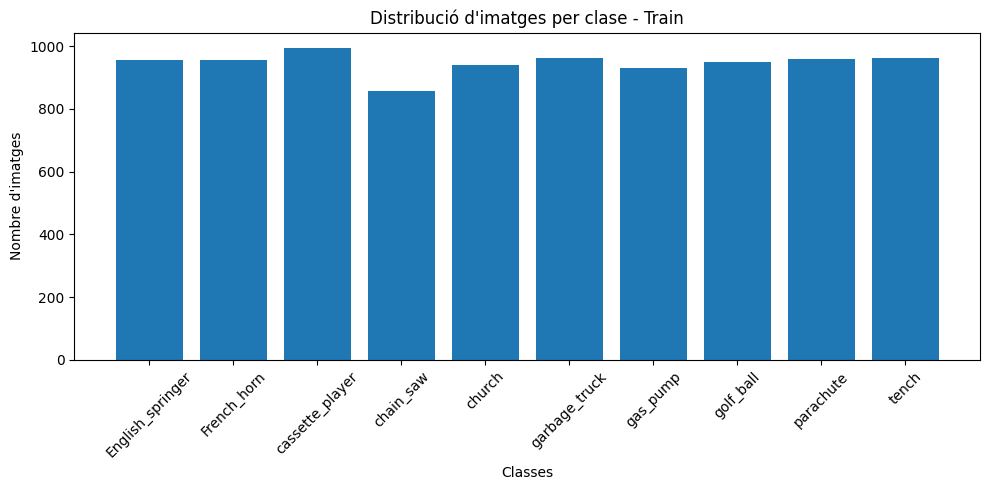

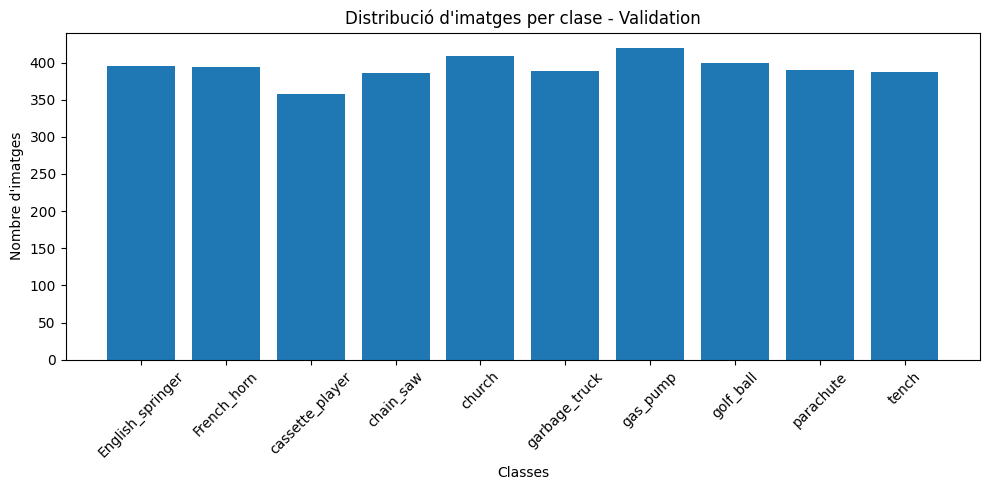

In [9]:
# Representació gràfica de la distribució de classes
plt.figure(figsize=(10, 5))
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Distribució d'imatges per clase - Train")
plt.xlabel("Classes")
plt.ylabel("Nombre d'imatges")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(val_counts.keys(), val_counts.values())
plt.title("Distribució d'imatges per clase - Validation")
plt.xlabel("Classes")
plt.ylabel("Nombre d'imatges")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Calcul del percentatge total
total_train = sum(train_counts.values())
total_val = sum(val_counts.values())
total_images = total_train + total_val

train_percentage = (total_train / total_images) * 100
val_percentage = (total_val / total_images) * 100

print(f"Percentatge d'imatges al conjunt Train: {train_percentage:.2f}%")
print(f"Percentatge d'imatges al conjunt Validation: {val_percentage:.2f}%")

Percentatge d'imatges al conjunt Train: 70.70%
Percentatge d'imatges al conjunt Validation: 29.30%


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong> Comentaris: </strong>
<br> <br>
        <ul>
        <li> <strong> Quin percentatge de les imatges totals correspon a cada conjunt (train/val)?</strong> El conjunt d'entrenament representa el 70% i el de validació el 30%.</li>
        <li> <strong> Segons els diagrames de barres, podem afirmar que la distribució per classes és similar en els dos conjunts?</strong> Sí, la distribució de classes és similar en els dos conjunts.</li>
        <li> <strong> Pel que fa al nombre d’imatges per classe, les classes estan equilibrades o hi ha desequilibris notables?</strong> Tot i que hi ha variacions en el nombre d'imatges per classe, les diferències no són notables i les classes estan equilibrades.</li>
    </ul>     
<br> <br>
</div>

### 1.2. Visualització d’imatges.

Ara examinarem el format de les imatges per entendre la seva mida i el seu rang de valors. Visualitzarem algunes imatges d’exemple de cada classe.

<div style = "background-color: #edf7ff; border-color: #7c9dbf; frontera-esquerra: 5px sòlid #7c9dbf; encoixinat: 0,5EM;"> <strong> Exercici 1.2 [0,5 pts]: </strong> Mostra com a exemple una imatge per a cada categoria del conjunt d'entrenament. A continuació, respon:
    <ul>
        <li> Tenen totes les imatges les mateixes dimensions (alçada × amplada)?
        <li> Quin és el rang dinàmic dels píxels (valors mínim i màxim) a les imatges?
        <li> Aquests valors són adequats per entrenar una xarxa neuronal?
        <li> Quines accions de pre-processament serien necessàries en relació a la pregunta anterior?
    </ul>
<strong> Nota: es valorarà la concisió en la resposta a les preguntes (una o dues frases són suficients per a cadascuna de les respostes).</strong>
</div>

Classe: English_springer, Dimensions: 320x480, Rang dinàmic: 0 - 255
Classe: French_horn, Dimensions: 426x320, Rang dinàmic: 0 - 255
Classe: cassette_player, Dimensions: 320x388, Rang dinàmic: 4 - 255
Classe: chain_saw, Dimensions: 426x320, Rang dinàmic: 0 - 255
Classe: church, Dimensions: 321x320, Rang dinàmic: 0 - 255
Classe: garbage_truck, Dimensions: 320x426, Rang dinàmic: 0 - 255
Classe: gas_pump, Dimensions: 320x426, Rang dinàmic: 0 - 255
Classe: golf_ball, Dimensions: 393x320, Rang dinàmic: 0 - 255
Classe: parachute, Dimensions: 320x451, Rang dinàmic: 0 - 255
Classe: tench, Dimensions: 320x426, Rang dinàmic: 0 - 255


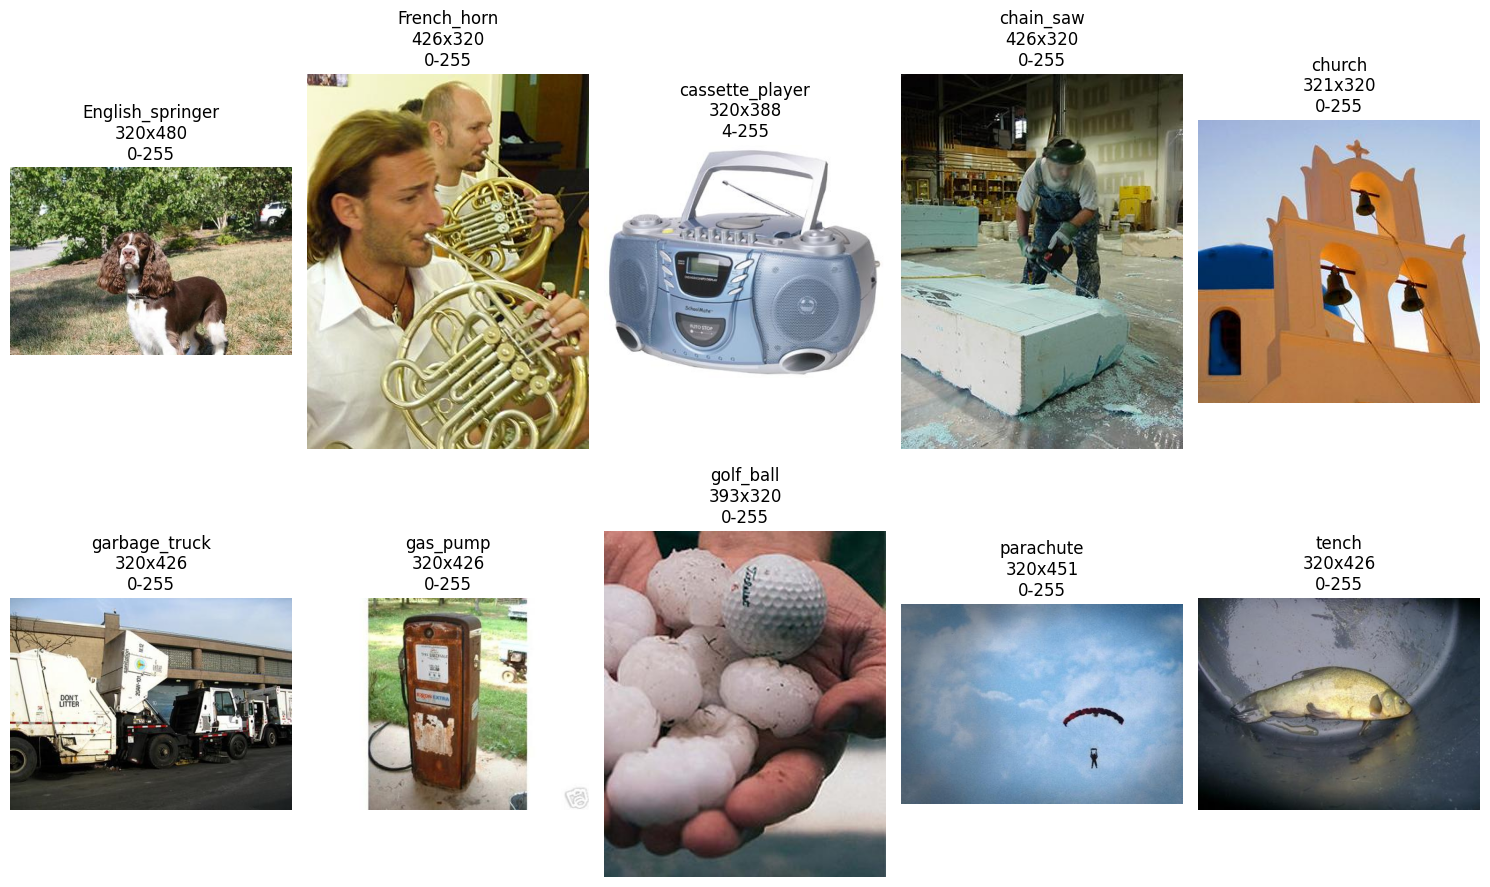

In [11]:
import random
from PIL import Image

plt.figure(figsize=(15, 10))
for i, classe in enumerate(train_classes):
    classe_dir = train_dir / classe
    imatges = list(classe_dir.glob("*.JPEG"))
    if imatges:
        imatge_path = random.choice(imatges)
        imatge = Image.open(imatge_path)
        imatge_array = np.array(imatge)
        
        ample, alt = imatge.size
        
        valor_min = imatge_array.min()
        valor_max = imatge_array.max()
        
        plt.subplot(2, 5, i+1)
        plt.imshow(imatge)
        plt.title(f"{classe}\n{alt}x{ample}\n{valor_min}-{valor_max}")
        plt.axis("off")
        
        print(f"Classe: {classe}, Dimensions: {alt}x{ample}, Rang dinàmic: {valor_min} - {valor_max}")

plt.tight_layout()
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong> Comentaris: </strong>
<br> <br>
        <ul>
        <li> <strong> Mida </strong>: Les imatges tenen mides diferents. Per exemple n'hi ha de 426x320 i de 393x320, entre d'altres.</li>
        <li> <strong> Rang dinàmic </strong>: El rang és de 0 a 255. </li>
        <li> <strong> Adequació per a la xarxa </strong>: Tot i que el rang dinàmic és adequat, les diferències en la mida de les imatges pot donar problemes en l'entrenament. </li>
        <li> <strong> Accions necessàries </strong>: S'ha de redimensionar les imatges a una mida estàndard i normalitzar els valors dels píxels (per exemple a l'escala [0,1]), fent que hi pugui haver una millor convergència en l'entrenament.</li>
    </ul>
</div>

### 1.3. Creació dels conjunts de dades en format Keras/TensorFlow

A continuació, prepararem les dades per a l'entrenament amb Keras. Utilitzarem la funció <code>**tf.keras.utils.image_dataset_from_directory()**</code> de TensorFlow/Keras, que permet crear lots de dades etiquetats en funció dels directoris d'imatges organitzats per classe.

La documentació d'aquesta funció es troba tant al lloc web de [Keras](https://keras.io/api/data_loading/image/) com al de [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

Aquesta funció ens facilitarà generar conjunts d'entrenament, validació i prova a partir de les carpetes analitzades. Les imatges es re-dimensionaran a una mida fixa i s’organitzaran en lots (batch).

**Especificacions**: convertirem les imatges a la mida de 160 × 160 píxels i les agruparem en lots de 64 imatges. També separarem part de les dades de prova a partir de les de validació.


<div style = "background-color: #edf7ff; border-color: #7c9dbf; fronter-esquerra: 5px sòlid #7c9dbf; encoixinat: 0,5EM;"> <strong> Exercici 1.3 [0,5 pts]: </strong> Utilitzeu la funció <code>tf.keras.utils.image_dataset_from_directory () </code> per generar 3 conjunts de dades a partir de les carpetes <code>/train</code> i <code>/val</code>:
<ul>
  <li><strong>train_ds</strong>: Conjunt d'entrenament a partir de <code>/train/</code>. Redimensiona les imatges a 160×160, amb <code>batch_size=64</code> i <code>label_mode="categorical"</code> (10 categories).</li>
  <li><strong>val_ds</strong>: Conjunt de validació a partir del directori <code>/val/</code>, amb un <code>validation_split</code> de 0.5 usant <code>subset="validation"</code> a la funció i fixa un <code>seed</code> per a reproducibilitat. De nou redimensiona les imatges a 160x160 amb <code>batch_size=64</code> i <code>label_mode="categorical"</code>.</li>
  <li><strong>test_ds</strong>: Conjunt de test a partir del mateix directori <code>/val/</code> usant <code>subset="training"</code> a la funció (amb el mateix <code>seed</code> per obtenir la partició complementària). Redimensiona també a 160×160 amb <code>batch_size=64</code> i fes servir <code>label_mode="categorical"</code>.</li>
 </ul>
<strong>NOTA</strong>: l'assignació de <code>subset="validation"</code> i <code>subset="training"</code> és completament arbitrària i podria haver-se fet al revés. L'important és dividir les dades que es troben a la carpeta <code>/val</code> al 50% entre validació i test.
 <br><br>
Comproveu que la base de dades s'ha creat correctament imprimint per pantalla els noms de les classes i les dimensions de cada conjunt de dades.

Respon les preguntes següents:
 <ul>
  <li>Quin percentatge aproximat de les imatges s'utilitza a cadascun dels 3 conjunts?</li>
  <li>Quins altres percentatges se solen utilitzar?</li>
 </ul>
<strong>NOTA: Es valorarà la concisió en la resposta a les preguntes (una o dues frases són suficients per cadascuna de les respostes).</strong>
</div>

In [51]:
img_height, img_width = 160, 160
batch_size = 64
seed = 42

# Conjunt d'entrenament
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
)

Found 9469 files belonging to 10 classes.


In [52]:
# Conjunt de validació i test (usem el directori de validació d'Imagenette també per a test)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    validation_split=0.5,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    validation_split=0.5,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
)

Found 3925 files belonging to 10 classes.
Using 1962 files for validation.
Found 3925 files belonging to 10 classes.
Using 1963 files for training.


In [14]:
# Comprovació dels resultats
def imprimeix_info(dataset, nom):
    for imatges, etiquetes in dataset.take(1):
        print(f"{nom}: Imatges {imatges.shape}, Etiquetes {etiquetes.shape}")

imprimeix_info(train_dataset, "Train")
imprimeix_info(val_dataset, "Validation")
imprimeix_info(test_dataset, "Test")

Train: Imatges (64, 160, 160, 3), Etiquetes (64, 10)
Validation: Imatges (64, 160, 160, 3), Etiquetes (64, 10)
Test: Imatges (64, 160, 160, 3), Etiquetes (64, 10)


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br> <br>
Podem veure que els conjunts s'han creat correctament, amb 10 classes i lots amb la forma (64,160,160,3); batch size, alçada, amplada i nombre de canals de color (RGB).

Del total d'imatges s'esta fent servir un 70% per entrenament, un 15% per validació i un 15% per testing. Una altre partició típica seria 80% per entrenament, 10% per validació i 10% per a testing.
<br> <br>
</div>

## 2. Xarxa neuronal artificial (ANN) completament connectada (1,5 pts)

Com a primer model, entrenarem una xarxa neuronal **completament connectada** (xarxa densa o <it>Multilayer Perceptron</it>) per **classificar les imatges**. Això servirà de model de referència (línia de base). Atès que la gestió d’imatges de 160×160 píxels directament amb capes denses donaria lloc a vectors d’entrada molt grans i, per tant, un gran nombre de paràmetres, primer aplicarem una reducció de la dimensionalitat de les imatges d’entrada. Concretament, reduirem cada imatge a 32×32 píxels (mitjançant una capa de redimensionat) abans d’aplanar-la, que simplificarà el model.

**Arquitectura proposada**: Utilitzarem l’API funcional de Keras (classe Model) per construir la xarxa. Utilitzarem les capes Resizing i Rescaling de Keras per preparar les imatges, seguides de Flatten per aplanar-les, i diverses capes Dense intercalades amb Dropout pel classificador.

En aquesta secció utilitzarem les capes [Resizing](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/resizing/), [Rescaling](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/), [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/), [Dense](https://keras.io/api/layers/core_layers/dense/) i [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de Keras.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Exercici 2.1 [0,5 pts]:</strong> Implementa un model <strong>funcional</strong> de Keras amb les següents característiques:
<ul>
   <li>Una capa que redueixi les dimensions d'entrada de (160,160) a (32,32).</li>
   <li>Una capa de reescalat perquè els valors de píxel quedin entre 0 i 1.</li>
   <li>Una capa Flatten per convertir la imatge reduïda en un vector 1D.</li>
   <li>Una capa densa completament connectada que tingui un nombre de neurones equivalent a dos terços de la mida de la capa anterior, activació ReLU.</li>
   <li>Una capa Dropout amb probabilitat 0.5.</li>
   <li>Una altra capa densa de la meitat de la mida que la capa densa inmediatament anterior, activació ReLU.</li>
   <li>Una altra capa Dropout amb probabilitat 0.5.</li>
   <li>Una capa de sortida densa amb la mida i la funció d'activació adequades per al problema de classificació que es planteja.</li>
 </ul>
<strong>Nota: Visualitzar els models de tots els exercicis amb la funció <code>summary()</code></strong>
<br><br>
Contestar les preguntes següents:
 <ul>
     <li>Quina mida hauria de tenir la capa d'entrada si haguéssim treballat amb les imatges de la base de dades directament de 160x160 píxels?</li>
     <li>Quina reducció s'aconsegueix en reescalar les imatges a 32x32 píxels?</li>
      <li>Quants paràmetres té el model?</li>
 </ul>

<strong>NOTA: Es valorarà la concisió en la resposta a les preguntes (una o dues frases són suficients per a cadascuna de les respostes).</strong>
</div>

In [15]:
# Construcció del model ANN completament connectat (model funcional)
from keras import layers, Model

def ANN_model():
    # Cada d'entrada
    input_shape = (160, 160, 3)
    inputs = Input(shape=input_shape)
    
    # 160x160 -> 32x32
    x = layers.Resizing(32, 32)(inputs)
    
    # Reescalat valors píxel entre 0 i 1
    x = layers.Rescaling(1./255)(x)
    
    # Flatten (32x32x3 = 3072 elements)
    x = layers.Flatten()(x)
    
    # Capa densa de 3072*2/3 = 2048 elements, activació ReLu i Dropout
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Capa densa de 2048*1/2 = 1024 elements, activació ReLu i Dropout
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Capa de sortida amb 10 neurones (una per classe) i softmax (classificació multiclasse)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = ANN_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       6,293,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,401,930 (32.05 MB)

 Trainable params: 8,401,930 (32.05 MB)

 Non-trainable params: 0 (0.00 B)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br> <br>
 <ul>
     <li><strong>Quina mida hauria de tenir la capa d'entrada si haguéssim treballat amb les imatges de la base de dades directament de 160x160 píxels?</strong> La capa d'entrada hauria de ser de (160,160,3).</li> 
     <li><strong>Quina reducció s'aconsegueix en reescalar les imatges a 32x32 píxels?</strong> Es redueix el nombre de píxels, de 160x160=25600 a 32x32=1024, una reducció de factor 25.</li>
      <li><strong>Quants paràmetres té el model?</strong> El model té 8,401,930 paràmetres. 3072*2048+2048=6,293,504 (primera capa densa); 2048*1024+1024=2,098,176 (segona capa densa); 1024*10+10=10,250 (capa de sortida)</li>
 </ul>
<br> <br>
</div>

Procedim a compilar i entrenar el model:
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong> Exercici 2.2 [1 PTS]: </strong> Quan entreneu qualsevol model, és essencial fer una bona elecció dels hiperparameters. En aquest exercici compilarem i entrenarem el model creat analitzant els efectes del <em>learning rate</em> en l'entrenament. Concretament, provarem els valors de 1e-3, 1e-4 i 1e-5.

Per a cada valor de <em>learning rate</em> es demana:
<ul>
   <li> Compileu el model amb l'optimitzador <strong>Adam</strong> i el corresponent <em>learning rate</em>.</li>
   <li>
        Entrena el model durant <strong>100 epochs</strong>, mitjançant:
        <ul>
            <li><em>EarlyStopping</em> monitoritzant la pèrdua (<em>loss</em>) en validació, amb paciència de 10 epochs, restablint els millors pesos obtinguts.
            <li><em>ReduceLROnPlateau</em> monitoritzant la pèrdua (<em>loss</em>) en validació, factor 0,2, paciència de 5 epochs i un <em>learning rate</em> mínim de 1e-6 </i>
            <li> La mètrica de rendiment <em>accuracy</em> tant en entrenament com en validació.
        </ul>
   </li>
   <li> Gràfic de de les corbes de <em>accuracy</em> i <em>loss</em> per als conjunts d'entrenament i validació.
   <li> Finalment, avalueu el model entrenat al conjunt de test, mostrant la pèrdua (<em>loss</em>) i la precisió (<em>accuracy</em>) obtingudes en aquestes dades.
</ul>

Feu una comparació de l'efecte del <em>learning rate</em> en els 3 entrenaments basada en:
    <ul>
        <li> Número d’èpoques/temps d’entrenament.
        <li> Forma de les corbes d’entrenament.
        <li> Rendiment del model al conjunt de prova (test).
        <li> Quina taxa d’aprenentatge seleccionaries en funció del que s'ha comentat en els punts anteriors?
    </ul>

<strong> Nota: es valorarà la concisió a les preguntes (una o dues frases són suficients per a cadascuna de les respostes).
</div>

Comencem amb lr = 1e-3

In [16]:
# Compilació del model
lr = 1e-3

# Guardem les dades de l'entrenament i eval per fer el plot en un diccionari
hist = {}
eval_results = {}

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
# Definir callbacks: EarlyStopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Entrenament del model
hist = model.fit(train_dataset, 
                 validation_data=val_dataset, 
                 epochs=100, 
                 callbacks=callbacks)

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.1512 - loss: 3.1145 - val_accuracy: 0.2971 - val_loss: 2.0193 - learning_rate: 0.0010
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.2405 - loss: 2.1078 - val_accuracy: 0.2951 - val_loss: 2.0005 - learning_rate: 0.0010
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2519 - loss: 2.0991 - val_accuracy: 0.3140 - val_loss: 1.9567 - learning_rate: 0.0010
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2563 - loss: 2.0524 - val_accuracy: 0.3359 - val_loss: 1.9592 - learning_rate: 0.0010
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2602 - loss: 2.0343 - val_accuracy: 0.3542 - val_loss: 1.9346 - learning_rate: 0.0010
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.2801 - loss: 2.0207 - val_accuracy: 0.3792 - val_loss: 1.9003 - learning_rate: 0.0010
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.2972 -

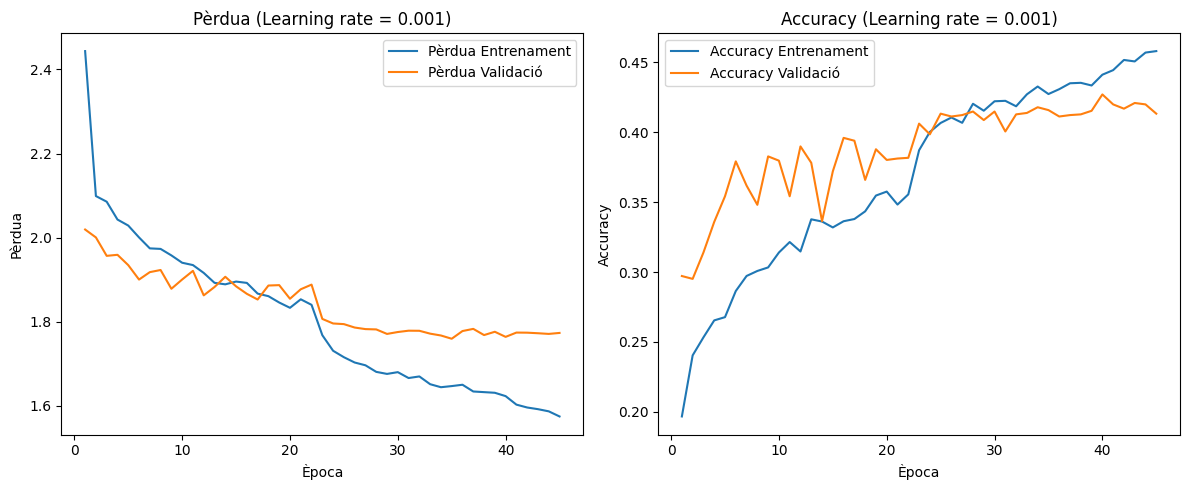

In [18]:
# Funció auxiliar per graficar accuracy i loss
def grafica_accuracy_loss(hist, lr):
    """
    Funció auxiliar per graficar les corbes de loss i accuracy de l'entrenament i validació.
    """
    epochs = range(1, len(hist.history['loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Gràfic de la pèrdua (loss)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist.history['loss'], label='Pèrdua Entrenament')
    plt.plot(epochs, hist.history['val_loss'], label='Pèrdua Validació')
    plt.title(f"Pèrdua (Learning rate = {lr})")
    plt.xlabel("Època")
    plt.ylabel("Pèrdua")
    plt.legend()
    
    # Gràfic de l'accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist.history['accuracy'], label='Accuracy Entrenament')
    plt.plot(epochs, hist.history['val_accuracy'], label='Accuracy Validació')
    plt.title(f"Accuracy (Learning rate = {lr})")
    plt.xlabel("Època")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

grafica_accuracy_loss(hist, lr)    

In [19]:
# Validació al conjunt de prova
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Pèrdua al conjunt de test: {test_loss:.4f}")
print(f"Accuracy al conjunt de test: {test_accuracy:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.3864 - loss: 1.8106
Pèrdua al conjunt de test: 1.8185
Accuracy al conjunt de test: 0.3923


Repetim amb lr = 1e-4

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.1723 - loss: 2.3385 - val_accuracy: 0.2895 - val_loss: 2.0008 - learning_rate: 1.0000e-04
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.2747 - loss: 2.0615 - val_accuracy: 0.3496 - val_loss: 1.9361 - learning_rate: 1.0000e-04
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.3096 - loss: 1.9859 - val_accuracy: 0.3624 - val_loss: 1.8784 - learning_rate: 1.0000e-04
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.3363 - loss: 1.9284 - val_accuracy: 0.3812 - val_loss: 1.8274 - learning_rate: 1.0000e-04
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.3449 - loss: 1.8995 - val_accuracy: 0.3981 - val_loss: 1.7952 - learning_rate: 1.0000e-04
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.3636 - loss: 1.8487 - val_accuracy: 0.4113 - val_loss: 1.7742 - learning_rate: 1.0000e-04
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/st

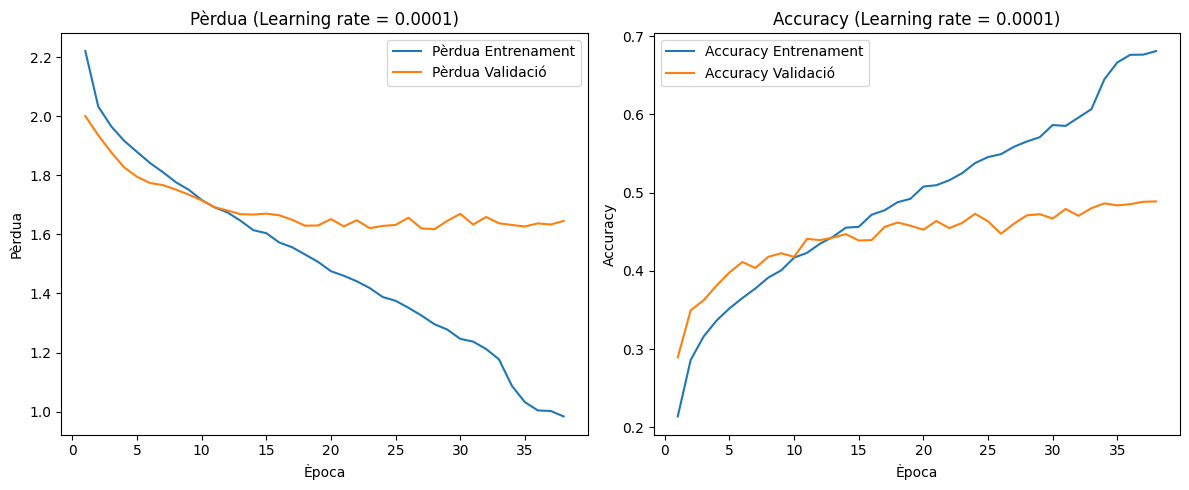

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4431 - loss: 1.6269
Pèrdua al conjunt de prova: 1.6378
Accuracy al conjunt de prova: 0.4412


In [20]:
lr = 1e-4

# Crear un nou model sense pesos previs
model = ANN_model()

# Compilació del model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Definir callbacks: EarlyStopping
# Fet anteriorment

# Entrenament del model
hist = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks
)

grafica_accuracy_loss(hist, lr)

# Validació al conjunt de prova
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Pèrdua al conjunt de prova: {test_loss:.4f}")
print(f"Accuracy al conjunt de prova: {test_accuracy:.4f}")

Acabem amb lr = 1e-5

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.1210 - loss: 2.4957 - val_accuracy: 0.2503 - val_loss: 2.1291 - learning_rate: 1.0000e-05
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.1963 - loss: 2.2288 - val_accuracy: 0.2808 - val_loss: 2.0486 - learning_rate: 1.0000e-05
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2440 - loss: 2.1201 - val_accuracy: 0.2977 - val_loss: 1.9966 - learning_rate: 1.0000e-05
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.2769 - loss: 2.0597 - val_accuracy: 0.3257 - val_loss: 1.9560 - learning_rate: 1.0000e-05
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2894 - loss: 2.0211 - val_accuracy: 0.3313 - val_loss: 1.9306 - learning_rate: 1.0000e-05
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.3069 - loss: 1.9892 - val_accuracy: 0.3517 - val_loss: 1.9063 - learning_rate: 1.0000e-05
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/st

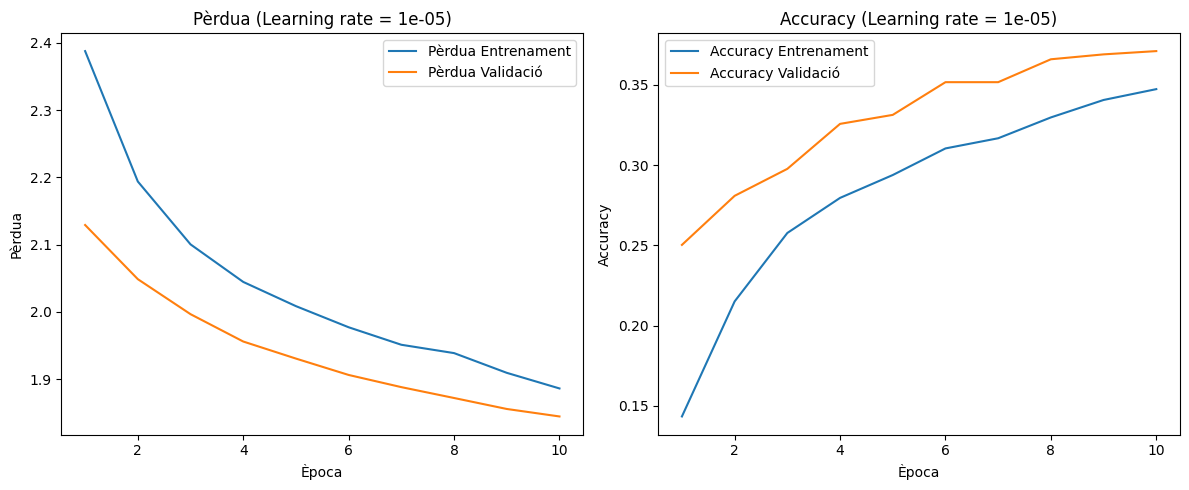

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2736 - loss: 2.1254
Pèrdua al conjunt de prova: 2.1402
Accuracy al conjunt de prova: 0.2547


In [21]:
lr = 1e-5

# Crear un nou model sense pesos previs
model = ANN_model()

# Compilació del model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Definir callbacks: EarlyStopping
# Fet anteriorment

# Entrenament del model
hist = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks
)

grafica_accuracy_loss(hist, lr)

# Validació al conjunt de prova
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Pèrdua al conjunt de prova: {test_loss:.4f}")
print(f"Accuracy al conjunt de prova: {test_accuracy:.4f}")

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
    <ul>
        <li> <strong> Forma de les corbes d'entrenament </strong>: A mesura que el learning rate baixa, les corbes de pèrdua es tornen més suaus i estables. Amb lr = 0.001, la pèrdua de validació deixa de millorar ràpidament, indicant sobreajustament. En canvi, amb lr=1e-5, la reducció de la pèrdua és progressiva i estable</li>
        <li> <strong> Número d’èpoques/temps d’entrenament </strong>: Quan menor és el learning rate, major és el nombre d'èpoques que es necessiten per arribar a una millora significativa. Menys en el cas de lr = 1e-5 el Early Stopping ha parat l'entrenament en les primeres èpoques, segurament degut a que s'ha quedat en un mínim subòptim..</li>        
        <li> <strong> Rendiment del model al conjunt de prova</strong>: El millor resultat s'ha obtingut amb lr=0.0001 (44%), seguit molt aprop per lr=1e-3 (40%). Amb lr=1e-5, el rendiment baixa fins a 25%, cosa que ens indica que l'aprenentatge s'ha quedat en un punt subòptim.</li>
        <li> <strong>Elecció final </strong>: El learning rate òptim sembla ser 0.0001, ja que és el que ha donat un millor rendiment amb un nombre d'èpoques raonable.</li>
    </ul>
</div>

## 3. Petita xarxa convolucional (2 punts)

Ara implementarem una xarxa neuronal convolucional bàsica (CNN), que sol ser molt més eficaç per a la classificació de les imatges. Les CNN aprofiten l'estructura espacial de les dades mitjançant capes específiques que permeten extreure les característiques locals abans de la classificació.

**Arquitectura proposada**: Utilitzarem un model de Keras Sequential per a aquesta CNN. Consistirà en un bloc d’extractor de característiques i, a continuació, un classificador dens similar a l'anterior però més petit.

En aquesta secció utilitzarem les capes  [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/),  [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/), [Dense](https://keras.io/api/layers/core_layers/dense/) i [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de Keras.

Es proporciona el codi del classificador ja implementat.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Exercici 3.1 [0,5 pts]:</strong> Analitza el codi següent i descriu les capes que formen el bloc extractor de característiques i el classificador.</div>

In [22]:
# Definició del model CNN
cnn_model = keras.Sequential([
    keras.layers.InputLayer(shape=(img_height, img_width, 3)),
    Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
], name="CNN_model")
cnn_model.summary()

Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 160, 160, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 80, 80, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 80, 80, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 20, 20, 64)          │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 20, 20, 10)          │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,394 (110.91 KB)

 Trainable params: 28,394 (110.91 KB)

 Non-trainable params: 0 (0.00 B)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Resposta: </strong>
<br>
 <ul>
     <li> <u>Bloc convolucional:</u> El bloc d'extracció de característiques està format per capes convolucionals i de max-pooling. Les capes Conv2D detecten patrons en les imatges. Es fa servir activació ReLu per introduir no linealitat. Les capes de MaxPooling2D serveixen per reduïr la dimensió, conservant la informació rellevant i baixant la complexitat de computació.</li>
     <li> <u>Classificador final:</u> El classificador està format per capes Dense totalment connectades. La primera té 64 neurones amb activació ReLu i es fa servir per interpretar les característiques extretes. Es fa un dropout del 50% per evitar els sobreajustament. Finalment, es fa servir una capa densa de 10 neurones amb activació softmax per tindre la distribució de probabilitats per classificar imatges en 10 categories.</li>
 <ul>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Exercici 3.2 [0.5 pts]</strong>: Compila el model amb l'optimitzador <strong>Adam</strong> i <em>learning rate</em> = 1e-4. Entrena el model durant <strong>100 èpoques</strong>, utilitzant:
    <ul>
        <li><em>EarlyStopping</em> monitoritzant la pèrdua (<em>loss</em>) en validació, amb paciència de 10 èpoques, restaurant els millors pesos obtinguts.</li>
        <li><em>ReduceLROnPlateau</em> monitoritzant la pèrdua (<em>loss</em>) en validació, factor 0.2, paciència de 5 èpoques i un learning rate mínim de 1e-6</i>
        <li>La mètrica de rendiment <em>accuracy</em> tant en entrenament com en validació.</li>
    </ul>

Mostra una gràfica de les corbes d'accuracy i loss per als conjunts d'entrenament i validació.

Finalment, avalua el model entrenat sobre el conjunt de <test>test</test>, mostrant la pèrdua i exactitud (<it>accuracy</it>) final obtingudes en aquestes dades.

<strong>Nota: durant l'execució del codi es produirà un error.</strong>

Explica a què és degut l'error en l'execució anterior i modifica el model per solucionar-lo.

<strong> Nota: es valorarà la concisió a les preguntes (una o dues frases són suficients per a cadascuna de les respostes).
</div>

In [23]:
# Compilar model CNN
cnn_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [24]:
# Definir callbacks EarlyStopping y ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

In [25]:
# Entrenament del model CNN
hist = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 10), output.shape=(None, 20, 20, 10)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br>
<br>
El problema està a la sortida del bloc convolucional. Aquesta té com a sortida un tensor 4D i la capa Dense espera un tensor 2D. Per tant, fa falta afegir una capa Flatten().
<br> <br>
</div>

In [26]:
# Escriu aquí el model corregit
cnn_model = keras.Sequential([
    keras.layers.InputLayer(shape=(img_height, img_width, 3)),
    Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
], name="CNN_model")
cnn_model.summary()

Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 160, 160, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 80, 80, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 80, 80, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,662,698 (6.34 MB)

 Trainable params: 1,662,698 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Exercici 3.3 [0.5 pt]:</strong> Torna a repetir l'exercici anterior (entrenament, mostrar gràfiques i validació en el conjunt de test) amb el model corregit. Comenta la mida del model, el nombre d'epochs/temps d'entrenament, les corbes d'entrenament i els resultats de validació.
<br><br>
<strong>NOTA: Es valorarà la concisió en la resposta a les preguntes (una o dues frases són suficients per a cadascuna de les respostes).</strong>

</div>

In [27]:
# Compilar model CNN
lr = 1e-4
cnn_model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [28]:
# Definir callbacks EarlyStopping y ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

In [29]:
# Entrenament del model CNN
hist = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.1632 - loss: 2.2438 - val_accuracy: 0.3150 - val_loss: 1.9616 - learning_rate: 1.0000e-04
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.2945 - loss: 1.9902 - val_accuracy: 0.4475 - val_loss: 1.7958 - learning_rate: 1.0000e-04
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3547 - loss: 1.8605 - val_accuracy: 0.4715 - val_loss: 1.6791 - learning_rate: 1.0000e-04
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.3864 - loss: 1.7710 - val_accuracy: 0.5041 - val_loss: 1.5694 - learning_rate: 1.0000e-04
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.4215 - loss: 1.6727 - val_accuracy: 0.5153 - val_loss: 1.5245 - learning_rate: 1.0000e-04
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4552 - loss: 1.6191 - val_accuracy: 0.5469 - val_loss: 1.4411 - learning_rate: 1.0000e-04
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/st

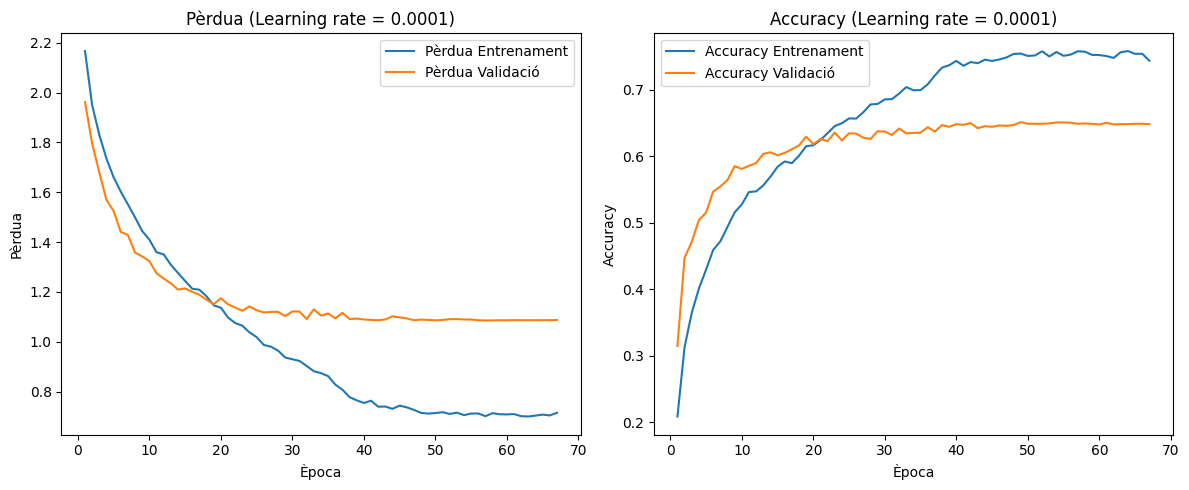

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6587 - loss: 1.0985
Pèrdua al conjunt de prova: 1.1145
Accuracy al conjunt de prova: 0.6490


In [31]:
# Resultats
grafica_accuracy_loss(hist, lr)

# Validació al conjunt de prova
test_loss, test_accuracy = cnn_model.evaluate(test_dataset)
print(f"Pèrdua al conjunt de prova: {test_loss:.4f}")
print(f"Accuracy al conjunt de prova: {test_accuracy:.4f}")

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br>
<br>
Tot i ser un model més gran que l'anterior (al voltant d'uns 60 cops) amb 1,662,698 paràmetres, encara no es tracta d'un model gran. Per exmple, el model VGG16, que també és un està basat en CNN té 138 millons de paràmetres.

Pel que fa a l'entrenament, no s'han dut a terme totes les èpoques, ja que l'early stopping ha parat l'entrenament a la època 47.

Les corbes presenten una reducció de la pèrdua i un increment progressiu de l'accuracy. No hi ha signes de sobreajustament.

S'ha obtingut un accuracy al voltant del 65%, és un resultat acceptable però amb marge de millora.
<br> <br>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Exercici 3.4 [0.5 pt]:</strong> Realitza una comparativa entre els models dels exercicis 2 (amb el <em>learning rate</em> escollit) i 3 en termes de:
<ul>
  <li> <strong> Mida del model </strong> </li>
  <li> <strong> Evolució de l'entrenament </strong> </li>
  <li> <strong> Validació en el conjunt de prova </strong> </li>
  <li> <strong> Temps d'execució </strong> </li>
</ul>

<strong> Nota: es valorarà la concisió a les preguntes (una o dues frases són suficients per a cadascuna de les respostes).

</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<ul>
  <li> <strong>Mida del model</strong>: El segon model, amb 1,662,698 paràmetres és unes 60 vegades més gran que el primer.</li>
  <li> <strong>Evolució de l'entrenament</strong>: el model ANN té una millora progressiva però menys estable en validació. Per una altre banda, la CNN convergeix més ràpidament.</li>
  <li> <strong>Validació en el conjunt de prova</strong>: El primer model té un 46% d'accuracy mentre que el segon arriba al 65%, tenint així un millor rendiment.</li>
  <li> <strong>Temps d'execució</strong>: El nombre d'èpoques entrenades per cada model és similar, ja que l'early stopping ha saltat en els dos casos. Pel que fa al temps, el model ANN ha trigat uns 6s per època i la CNN 7 segons; un temps d'entrenament que deixa clar perquè les CNN van millor per tractar imatges.</li>
</ul>
</div>

## 4. Augmentació de dades (1 punt)

Tot i que la CNN entrenada és força efectiva, podem intentar millorar-ne la generalització augmentant artificialment la mida i la diversitat del conjunt d'entrenament mitjançant **tècniques d'augmentació de dades**. L'augmentació consisteix a aplicar transformacions aleatòries a les imatges (girs, rotacions, zoom, etc.) de manera que el model rebi variants de les imatges originals a cada època, simulant tenir més dades

Keras proporciona capes de preprocessament d'imatge que realitzen aquestes transformacions de manera eficient durant l'entrenament, per exemple RandomFlip, RandomRotation, RandomZoom entre d'altres.

Aquí farem servir algunes d'aquestes capes per implementar l'augment. En particular, provarem de voltejar horitzontalment les imatges i aplicar petites rotacions aleatòries.

### 4.1. Definició i visualització de l'augmentació

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Exercici 4.1 [0,5 pts]:</strong> Crea un model <strong>Sequential</strong> de Keras que representi una capa d'augmentació de dades amb les següents capes:
  <ul>
      <li><code>RandomFlip</code> que voltegi aleatòriament les imatges horitzontalment.</li>
      <li><code>RandomRotation</code> amb factor de rotació de 0.1 (±10%).</li>
  </ul>
Selecciona una imatge del conjunt d'entrenament i passa-la a través d'aquest model diverses vegades, mostrant les imatges resultants per comprovar visualment les transformacions realitzades (voltejos i rotacions).
</div>

In [32]:
from tensorflow.keras import layers

# Model d'augmentació de dades
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),    # Volteig horitzontal
    layers.RandomRotation(0.1)          # Rotació ±10%
], name="data_augmentation")

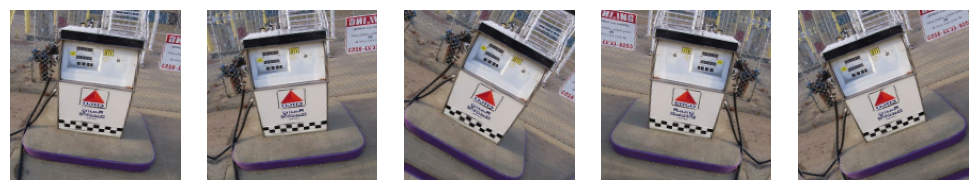

In [33]:
# Prendre un batch d'entrenament i obtenir una imatge
for images, labels in train_dataset.take(1):
    sample_image = images[0]
    break

# Aplicar augmentació diverses vegades i visualitzar
plt.figure(figsize=(10, 2))
for i in range(5):
    augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
    
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")
plt.tight_layout()
plt.show()

### 4.2. Entrenament de la CNN amb augmentació

Ara incorporarem la capa d’augmentació al model CNN per entrenar-la amb dades augmentades a cada època.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Exercici 4.2 [0,5 pts]:</strong> Insereix el model d'augmentació de dades creat entre la capa de <code>Rescaling</code> i la primera <code>Conv2D</code> del model CNN anterior. És a dir, modifica l'arquitectura perquè les imatges d'entrada, després de ser reescalades, passin per les capes de <em>flip</em> i <em>rotation</em> aleatòries, i després continuïn per la CNN. A continuació, compila i entrena el nou model CNN augmentat seguint les mateixes indicacions que en l'exercici anterior, <strong>excepte</strong> que aquesta vegada farem servir un <strong>learning rate</strong> inicial més gran (1e-3). Mantingues EarlyStopping, ReduceLROnPlateau, 100 èpoques, etc. Després avalua el model final al conjunt de test.

Comenta les diferències amb el model sense augmentació en termes de:

<ul>
    <li> <strong> Evolució de les corbes d'entrenament </strong> </li>
    <li> <strong> Validació en el conjunt de prova </strong> </li>
    <li> <strong> Temps d'entrenament </strong> </li>
    <li> <strong> Learning rate </strong> </li>
</ul>

<strong> Nota: es valorarà la concisió a les preguntes (una o dues frases són suficients per a cadascuna de les respostes).

</div>

In [34]:
# Model CNN amb augmentació de dades
cnn_aug_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
], name="CNN_aug_model")

cnn_aug_model.summary()

Model: "CNN_aug_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 160, 160, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 80, 80, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 80, 80, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,662,698 (6.34 MB)

 Trainable params: 1,662,698 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Compilació de la xarxa
lr = 1e-3
cnn_aug_model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

In [36]:
# Entrenament
hist_aug = cnn_aug_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.2032 - loss: 2.1754 - val_accuracy: 0.4358 - val_loss: 1.7140 - learning_rate: 0.0010
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.3574 - loss: 1.8574 - val_accuracy: 0.5082 - val_loss: 1.5215 - learning_rate: 0.0010
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.4155 - loss: 1.6918 - val_accuracy: 0.5601 - val_loss: 1.3669 - learning_rate: 0.0010
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.4523 - loss: 1.6082 - val_accuracy: 0.5973 - val_loss: 1.2956 - learning_rate: 0.0010
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.4773 - loss: 1.5498 - val_accuracy: 0.6055 - val_loss: 1.2546 - learning_rate: 0.0010
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.4938 - loss: 1.5010 - val_accuracy: 0.6259 - val_loss: 1.1793 - learning_rate: 0.0010
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5044 - 

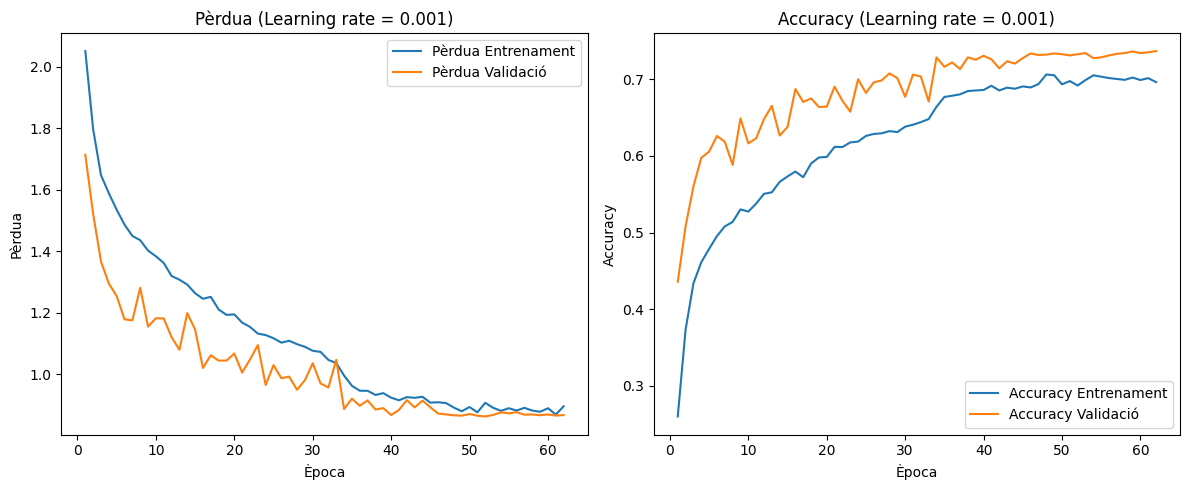

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7295 - loss: 0.8769
Pèrdua al conjunt de prova: 0.8662
Accuracy al conjunt de prova: 0.7341


In [37]:
# Resultats
grafica_accuracy_loss(hist_aug, lr)

test_loss, test_accuracy = cnn_aug_model.evaluate(test_dataset)
print(f"Pèrdua al conjunt de prova: {test_loss:.4f}")
print(f"Accuracy al conjunt de prova: {test_accuracy:.4f}")

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong> Comentaris: </strong>
<br> <br>

<ul>
  <li> <strong> Evolució de les corbes d'entrenament</strong>: Les pèrdues es redueixen de manera progressiva i l'accuracy augmenta fins a estabilitzar-se al voltant del 70% en entrenament i 68% en validació. </li>
  <li> <strong> Validació en el conjunt de prova</strong>: L'accuracy del conjunt de prova és del 73.41%, una millora respecte al model sense augmentació de dades. El model ha pogut generalitzar millor. </li>
  <li> <strong> Temps d'entrenament</strong>: El temps per època s'ha mantingut estable tot i l'augmentació de dades. </li>
  <li> <strong> Learning rate</strong>: Comença amb un valor de 1e-3, el model aprèn més ràpidament al principi i després s'ajusta el learning rate amb ReduceLROnPlateau per estabilutzar la convergència. </li>
</ul>

</div>

## 5. Superresolució d’imatges amb CNNs (2 pts)

Fins ara hem treballat en un problema de “classificació”. Als apartats restants abordarem un problema diferent però relacionat amb la visió per computador: la **superresolució d'imatges**. La superresolució consisteix a generar una imatge d'alta resolució (HR) a partir d'una de baixa resolució (LR), intentant recuperar o inferir els detalls perduts en reduir la imatge. És un problema d'aprenentatge supervisat on el model aprèn una transformació imatge->imatge.

Farem servir novament la base de dades Imagenette per crear exemples d'entrenament: a partir de cada imatge original (320px) generarem una versió reduïda (p. ex. 80px) que servirà com a entrada, tenint com a sortida esperada la imatge original. Així, el model aprendrà a mapejar de baixa a alta resolució. En lloc d'una xarxa convolucional per a la classificació, necessitarem una xarxa capaç de processar una imatge d'entrada i produir una imatge de sortida. Les **capes transposades de convolució** ([Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/)) o les tècniques de upsampling són les peces clau per a aquests models, ja que permeten augmentar les dimensions espacials de les dades.

A continuació, crearem el conjunt de dades per a superresolució i entrenarem una **CNN de superresolució simple**.

### 5.1. Preparació de dades de LR/HR

Primer generarem els parells d'imatges d'entrenament i de validació per a superresolució. Partirem de les imatges originals d'entrenament (i validació) a la seva resolució completa i, per simplicitat, les redimensionarem a una mida fixa de 320×320 (ignorant la relació d'aspecte original, similar al fet en classificació) per utilitzar-les com a imatges de referència d'alta resolució (HR), i les reduirem a 1/4 de la seva mida (aprox). Per realitzar ambdues transformacions (ajust de les imatges originals a 320x320 i la seva reducció a 80x80) utilitzarem mètodes d'[interpolació bicúbica](https://es.wikipedia.org/wiki/Interpolaci%C3%B3n_bic%C3%BAbica) per simular imatges degrades suaument.


Procedim a obtenir les rutes d'imatges d'entrenament i validació, després creem un Dataset aplicant la funció de mapeig que realitza la lectura i la transformació:

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Exercici 5.1.1 [0,5 pt]: </strong>El codi següent prepara un nou conjunt de dades a partir de les imatges d'entrenament originals. Cada exemple consistirà en una imatge de baixa resolució (LR) i la corresponent imatge d'alta resolució (HR). Concretament, pren les imatges de <code>/train/</code> (per crear els subconjunts d'entrenament i validació) a la seva mida completa (320px) com a HR, i genera imatges LR reduint-les a 1/4 de la seva mida lineal (80×80). Es demana:
<ul>
    <li> Completa els comentaris del codi en aquells llocs on està marcat (# Posar Comentari).
</ul>
</div>

In [38]:
import random

# Funció per preprocessar una imatge per resolució, genera un parell d'imatges:
# una de baixa resolució (LR) i la corresponent en alta resolució (HR)
def preprocess_image_for_sr(filepath):
    # Llegir el fitxer d'imatge en format JPEG des de la ruta indicada
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Convertir imatge a float32 i normalitzar els valors dels píxels a l'interval [0,1]
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Redimensió de la imatge a 320x320 per obtenir la versió HR
    # Redimensió de la imatge a 80x80 per obtenir la versió LR
    # Es fa servir el mètode BICUBIC per mantenir els detalls
    hr = tf.image.resize(img, [320, 320], method=tf.image.ResizeMethod.BICUBIC)
    lr = tf.image.resize(img, [80, 80], method=tf.image.ResizeMethod.BICUBIC)
    
    # Assegura que els valors dels píxels estan dintre de [0,1]
    hr = tf.clip_by_value(hr, 0.0, 1.0)
    lr = tf.clip_by_value(lr, 0.0, 1.0)
    return lr, hr

# Creació de llistes buides per emmagatzemar les rutes dels fitxers d'entrenament i validació
train_files = []
val_files = []
for cls in train_classes:
    cls_files = sorted((train_dir/cls).glob("*.*"))
    # Separació de fitxers 20% per validació i 80% per entrenament
    split_idx = int(len(cls_files) * 0.2)
    val_files += [str(p) for p in cls_files[:split_idx]]
    train_files += [str(p) for p in cls_files[split_idx:]]
random.shuffle(train_files)
random.shuffle(val_files)

# Creació dels Datasets per entrenament i validació
# Cada element està format per un parell (LR, HR)
train_sr_ds = tf.data.Dataset.from_tensor_slices(train_files).map(preprocess_image_for_sr, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
val_sr_ds   = tf.data.Dataset.from_tensor_slices(val_files).map(preprocess_image_for_sr, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

Procedim a verificar la base de dades:

In [39]:
# Verificació d'un parell LR-HR
for lr_batch, hr_batch in train_sr_ds.take(1):
    lr_img = lr_batch[0].numpy()
    hr_img = hr_batch[0].numpy()
    print("LR shape:", lr_img.shape, "HR shape:", hr_img.shape)
    print("LR pixel range:", lr_img.min(), "-", lr_img.max())
    print("HR pixel range:", hr_img.min(), "-", hr_img.max())
    break

LR shape: (80, 80, 3) HR shape: (320, 320, 3)
LR pixel range: 0.0 - 1.0
HR pixel range: 0.0 - 1.0


<div style = "background-color: #edf7ff; border-color: #7c9dbf; frontera-esquerra: 5px sòlid #7c9dbf; encoixinat: 0,5EM;"> <strong> Exercici 5.1.2 [0,5 pt]: </strong> Respon a les preguntes següents:
<ul>
 <li>A què es pot deure l'ús de la funció 'clip_by_value' al codi anterior?</li>
 <li>Com es divideix la base de dades? Quin directori s'utilitza per crear-la? Quins subconjunts es creen? Quin percentatge d'imatges s'assigna a cada conjunt? I en nombre d'imatges?</li>
 <li>Per a cada element del conjunt de dades, quin format tenen les dades que farem servir per entrenar el model? i les etiquetes?</li>
</ul>
<strong> Nota: es valorarà la concisió a les preguntes (una o dues frases són suficients per a cadascuna de les respostes).
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong> Comentaris: </strong>
<br> <br>
 <ul>
    <li> <strong> Funció 'clip_by_value' </strong>: Serveix per assegurar que després de redimensionar i convertir la imatge, els valors dels píxels queden tindre de l'interval [0,1]. </li>
    <li> <strong> Subconjunts de la base de dades </strong>: A parti del directori /train/ es divideixen en dos subconjunts: entrenament (80%) i validació (20%). </li>
    <li> <strong> Format de les dades i etiquetes </strong>: Cada element del dataset és un parell (LR, HR) on LR és un tensor float32 de dimensió 80x80x3 i HR és un float32 de dimensió 320x320x3. En aquest cas, l'estiqueta és la pròpia imatge d'alta resolució. </li>
</ul>
</div>

### 5.2. Implementació del model de Superresolució

Ara definim un model CNN per a Superresolució. Optarem per una arquitectura senzilla amb [UpSampling2D](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) per escalar la imatge gradualment. Implementem el model:

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong> Exercici 5.2 [1 pt]: </strong> Entrenarem un model CNN per superresolució 4× (de 80px a 320px). Per fer això:
    <ul>
        <li> Implementa un model de superresolució a Keras. Podeu utilitzar l’API funcional o Sequential. Suggeriment d'arquitectura simple:
            <ul>
                <li> Entrada amb forma (80,80,3).
                <li> Diverses capes Conv2D per extreure les característiques de les imatges de baixa resolució.
                <li> Capa de <code>Upsampling2D</code> (factor=2) o <code>Conv2DTranspose</code> amb <code>stride=2</code> per doblar l'amplada i alçada (80 -> 160).
                <li> Una altra capa Conv2D per refinar, seguida d'una altra capa upsampling 2× (160 -> 320).
                <li> Capes finals Conv2D per reconstruir la imatge de sortida 320×320×3. (Podeu utilitzar l'activació lineal o RELU per a la sortida; considereu que busquem valors de píxel entre 0-1 o 0-255).
            </ul> </li>
        <li> Compileu el model amb una funció de pèrdua adequada per a imatges (per exemple, MSE) i sense mètriques de precisió. Entreneu-lo durant ~ 50-100 epochs, amb EarlyStopping (paciència 5-10, monitorització de val_loss) per assegurar-vos que no sobreentreneu.
        <li> Comentar els resultats de l'entrenament. Concretament:
            <ul>
                <li> Corbes d'entrenament.
                <li> El temps d'entrenament vs Tamany del model.
            </ul>                
        </li>
    </ul>
<strong> Nota: es valorarà la concisió a les preguntes (una o dues frases són suficients per a cadascuna de les respostes).
</div>

In [40]:
from tensorflow.keras.models import Sequential

# Modelo de Superrsolució (80px -> 320px)
sr_model = Sequential([
    Input(shape=(80, 80, 3)),
    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    UpSampling2D(size=(2, 2)),  # 80x80 → 160x160
    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    UpSampling2D(size=(2, 2)),  # 160x160 → 320x320
    Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')
])
sr_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 80, 80, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 80, 80, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 160, 160, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 160, 160, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 320, 320, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 320, 320, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,379 (302.26 KB)

 Trainable params: 77,379 (302.26 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Compilació de la xarxa
lr = 1e-3

sr_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                 loss='mse')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [42]:
# Entrenament de la xarxa
hist = sr_model.fit(
    train_sr_ds,
    validation_data=val_sr_ds,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 73s 244ms/step - loss: 0.0265 - val_loss: 0.0065
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 167ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 7/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 8/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 9/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 10/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 11/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 12

In [1]:
def grafica_loss(hist, lr):
    """
    Funció auxiliar per dibuixar les corbes de loss de l'entrenament i validació.
    """
    epochs = range(1, len(hist.history['loss']) + 1)
    
    plt.figure(figsize=(6, 5))
    plt.plot(epochs, hist.history['loss'], label='Pèrdua Entrenament')
    plt.plot(epochs, hist.history['val_loss'], label='Pèrdua Validació')
    plt.title(f"Pèrdua (Learning rate = {lr})")
    plt.xlabel("Època")
    plt.ylabel("Pèrdua")
    plt.legend()
    plt.tight_layout()
    plt.show()

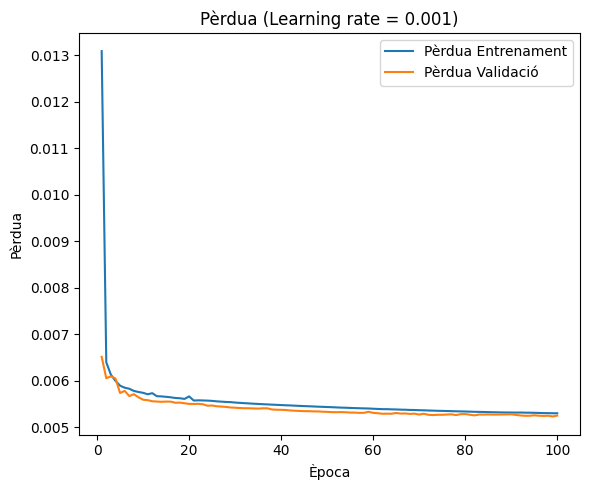

In [46]:
# Resultats
grafica_loss(hist, lr)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong> Comentaris: </strong>
<br> <br>
<ul>
    <li> <strong> Corbes d’entrenament </strong>: Es pot veure una ràpida convergència en les primeres èpoques (de 0.0265 a 0.0053). I una estabilització posterior tan a l'entrenament com en validació. El model ha après correctament a transformar de LR a HR. </li>
    <li> <strong> Temps d'entrenament vs Tamany del model </strong>: Encara que el model de superesolució té menys paràmetres entrenables, cada imatge s'ha de processar de forma més complexe, incrementan molt el temps de càlcul per batch i, per tant, el temps total.  </li>
</ul>
</div>

## 6. Inferència, mètriques i visualització dels resultats (1 punt)

Amb el model de superresolució entrenat, avaluarem el seu rendiment tant quantitativament (amb mètriques) com qualitativament (visualització d’imatges). Per fer -ho, realitzarem la inferència: és a dir, prendre imatges LR del conjunt de test, passar-les pel model <code>sr_model</code> per obtenir imatges supers resoltes (SR) i comparar-les amb les imatges HR originals. Calcularem la mètrica [PSNR (Peak Signal-to-Notise Ratio)](https://es.wikipedia.org/wiki/psnr) per quantificar la qualitat.

El PSNR es mesura en decibels (dB) i els valors superiors indiquen una major similitud amb la imatge original (per exemple,> 30 dB sol indicar una qualitat de reconstrucció molt bona).

També visualitzarem alguns exemples, on mostraren la imatge de baixa resolució (LR), la super resolta per la CNN (SR) i l’original d’alta resolució (HR), per inspeccionar els detalls amb l’ull nu.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong>Exercici 6 [1 pt]:</strong> Realitza la inferència del model de superresolució sobre diverses imatges de test:
<ul>
  <li>Per a cada imatge de test, obté la seva versió de baixa resolució (LR) i genera la imatge superresolta (SR) amb el model.</li>
  <li>Calcula la mètrica PSNR comparant la imatge SR amb la HR original per a tot el conjunt de test.</li>
  <li>Mostra visualment alguns exemples, incloent-hi la imatge d'entrada LR (pots ampliar-la per mostrar-la de la mateixa mida utilitzant el mètode <code>tf.image.resize()</code> juntament amb <code>method=tf.image.ResizeMethod.NEAREST_NEIGHBOR</code>), la imatge generada pel model (SR) i la imatge HR original, per poder comparar la qualitat visualment a part del valor de la PSNR.</li>
</ul>
Comentar els resultats obtinguts:
<ul>
    <li> Quins valors de PSNR s’obtenen? (Comenta tant els exemples mostrats com el valor mitjà del total del conjunt de prova) </li>
    <li> Les imatges creades amb superresolució són nítides o borroses?
    <li> Quins tipus de detalls o errors s’observen?
</ul>
<strong> Nota: es valorarà la concisió a les preguntes (una o dues frases són suficients per a cadascuna de les respostes).  
</div>

In [60]:
# Preparar conjunt de test per a superresolució (a partir del directori /val)
test_files = list(val_dir.glob("**/*.*"))

test_sr_ds = tf.data.Dataset.from_tensor_slices(
    tf.constant([str(file) for file in test_files], dtype=tf.string)
).map(preprocess_image_for_sr, num_parallel_calls=tf.data.AUTOTUNE) \
 .batch(1) \
 .prefetch(tf.data.AUTOTUNE)

In [62]:
# Llista per emmagatzemar la PSNR de cada imatge
psnr_list = []

# Recórrer el dataset de test (batch size = 1)
for lr_batch, hr_batch in test_sr_ds:
 # Generar la imatge de superresolució a partir de la imatge LR
    sr_pred = sr_model.predict(lr_batch, verbose=0)
 # Treure la dimensió de batch i assegurar que els valors estiguin a [0,1]
    sr_img = tf.squeeze(sr_pred, axis=0)
    sr_img = tf.clip_by_value(sr_img, 0.0, 1.0)
 # Convertir la imatge HR a array de numpy (llevem la dimensió de batch)
    hr_img = tf.squeeze(hr_batch, axis=0).numpy()
 # Calcular la PSNR entre la imatge SR generada i la imatge HR original
    psnr_value = tf.image.psnr(sr_img, hr_img, max_val=1.0)
 # Emmagatzemar el valor de PSNR a la llista
    psnr_list.append(psnr_value.numpy())

# Calcular la PSNR mitjana del conjunt de test
avg_psnr = np.mean(psnr_list)
print("PSNR mitjana al conjunt de test: {:.2f} dB".format(avg_psnr))

PSNR mitjana al conjunt de test: 24.10 dB


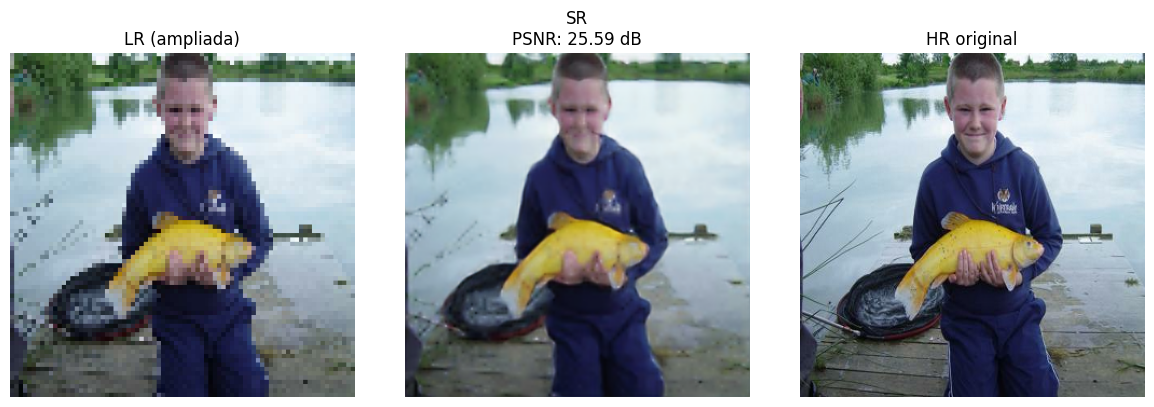

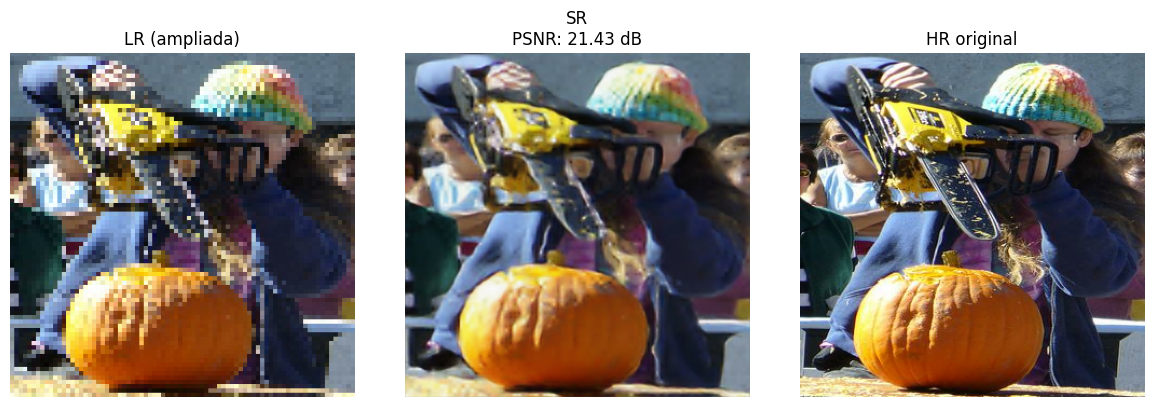

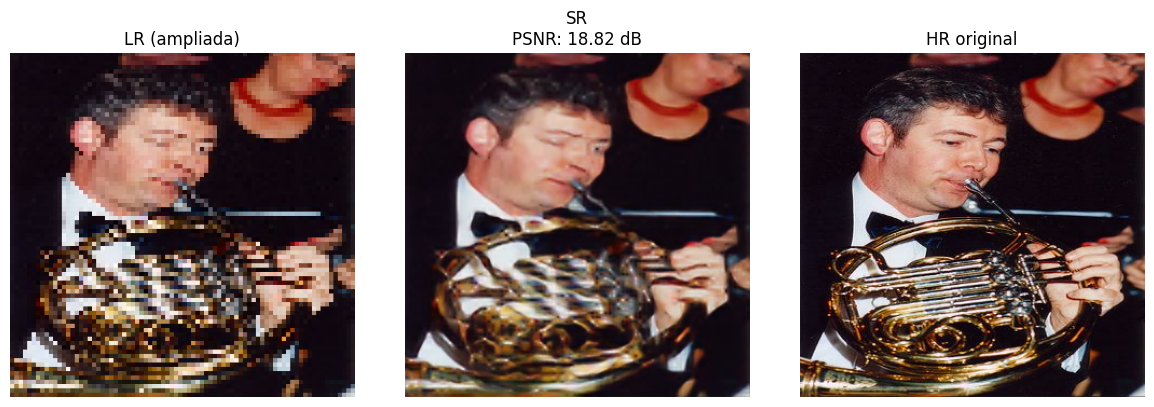

In [65]:
import math

# Escollir algunes imatges de test aleatòries per a visualització
sample_files = random.sample(test_files, 3)
# Per a cada imatge
for file in sample_files:
    # Llegir i processar una imatge de test
    lr, hr = preprocess_image_for_sr(str(file))
    # Generar superresolució
    lr_expanded = tf.expand_dims(lr, axis=0)
    sr = sr_model.predict(lr_expanded, verbose=0)
    sr = tf.squeeze(sr, axis=0)
    # Calcular PSNR
    psnr_img = tf.image.psnr(sr, hr, max_val=1.0).numpy()
    # Preparar imatges per visualitzar de la mateixa mida
    lr_up = tf.image.resize(lr, [320, 320], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Les imatges estan a [0,1], escalar a [0,255] per mostrar correctament
    lr_disp = (lr_up.numpy() * 255).astype(np.uint8)
    sr_disp = (sr.numpy() * 255).astype(np.uint8)
    hr_disp = (hr.numpy() * 255).astype(np.uint8)
    
    # Mostrar les imatges
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(lr_disp)
    plt.title("LR (ampliada)")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(sr_disp)
    plt.title("SR\nPSNR: {:.2f} dB".format(psnr_img))
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(hr_disp)
    plt.title("HR original")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()    

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong> Comentaris: </strong>
<br> <br>
   Anàlisi dels resultats del model SR:
   <ul>
       <li> <strong> PSNR </strong>: Els valors obtinguts oscil·len entre 18 i 25 dB, mostrant una reconstrucció raonablament bona però que no recupera tots els detalls de la imàtge original. No s'ha arribat a l'umbral dels 30 dB. </li>
       <li> <strong> Qualitat visual </strong>: Tot i que la versió SR és més nítida que la LR ampliada, es poden veure detalls en zones complexes com els ulls de la cara. </li>
       <li> <strong> Errors </strong>: Els contorns fins, les partes més detallades i els colors brillants semblen tindre una major pèrdua de la definició. </li>
   </ul>
</div>

## 7. Model pre-entrenat en superresolució (1 punt)

Els avenços recents en superresolució han produït arquitectures més complexes (p. ex., basades en xarxes generatives adversàries) que aconsegueixen resultats notablement millors, a costa d'un entrenament costós. Un d'aquests models és ESRGAN ([Enhanced Super-Resolution GAN per Xintao Wang et al.](https://arxiv.org/abs/1809.00219)), entrenat en grans bases de dades d'imatges HD (com DIV2K) per aconseguir superresolució 4x de gran fidelitat.

Farem servir un model pre-entrenat d'ESRGAN disponible via [TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/image_enhancing)

Aquest model ha estat entrenat al conjunt DIV2K (imatges d'alta qualitat) amb degradació bicúbica, per la qual cosa està especialitzat en produir imatges 4× més grans amb detall notable.

Farem servir ESRGAN per aplicar superresolució a les mateixes imatges de test i compararem els resultats amb el nostre model implementat a l'exercici 5.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong> Exercici 7 [1 pt]:</strong> Utilitza un model pre-entrenat de superresolució (p. ex. ESRGAN 4×) per millorar les imatges de baixa resolució. En concret:
  <ul>
      <li>Carrega el model pre-entrenat des de TensorFlow Hub (usa l'URL proporcionada, per exemple <code>"https://tfhub.dev/captain-pool/esrgan-tf2/1"</code>).</li>
      <li>Per a una selecció d'imatges de test de baixa resolució (80×80), obteniu la superresolució 4× amb aquest model.</li>
      <li>Calcula la PSNR de les imatges generades pel model pre-entrenat (en el total del conjunt de test) i compara la seva mitjana amb la PSNR mitjana obtinguda pel teu model.</li>
      <li>Visualitza les imatges de sortida del model pre-entrenat al costat de les del teu model i les originals, per comparar visualment la qualitat. Compara també la PSNR d'aquestes imatges.</li>
  </ul>
Discuteix les diferències observades:
  <ul>
      <li>El model pre-entrenat obté millors mètriques?</li>
      <li>El model pre-entrenat produeix imatges més nítides i properes a la realitat?</li>
      <li>En quins detalls es nota la millora?</li>
  </ul>
</div>

In [66]:
import tensorflow_hub as hub

# Carreguem el model ESRGAN des de TF-Hub:
esrgan = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
print("Model ESRGAN carregat.")

Model ESRGAN carregat.


In [68]:
# Llista per emmagatzemar la PSNR de cada imatge usant ESRGAN
psnr_esrgan_list = []

# Recórrer el dataset de test (batch size = 1)
for lr_batch, hr_batch in test_sr_ds:
 # Preparar la imatge LR per ESRGAN:
    # ESRGAN espera entrada en rang [0,255] com a float32, i test_sr_ds té imatges a [0,1]
    lr_255 = tf.clip_by_value(lr_batch * 255.0, 0.0, 255.0)
    # Generar la imatge de superresolució amb ESRGAN
    sr_esrgan_255 = esrgan(lr_255)
    # Treure la dimensió de batch i normalitzar la sortida a [0,1]
    sr_esrgan = tf.clip_by_value(sr_esrgan_255 / 255.0, 0.0, 1.0)
    # Obtenir la imatge HR corresponent (llevem la dimensió de batch)
    hr_img = tf.squeeze(hr_batch, axis=0)
    # Calcular la PSNR entre la imatge generada per ESRGAN i la imatge HR original
    psnr_val = tf.image.psnr(sr_esrgan, hr_img, max_val=1.0)
    psnr_esrgan_list.append(psnr_val.numpy())

# Calcular la PSNR mitjana en el conjunt de test amb ESRGAN
avg_psnr_esrgan = np.mean(psnr_esrgan_list)
print("PSNR mitjana en el conjunt de test amb ESRGAN: {:.2f} dB".format(avg_psnr_esrgan))

PSNR mitjana en el conjunt de test amb ESRGAN: 19.13 dB


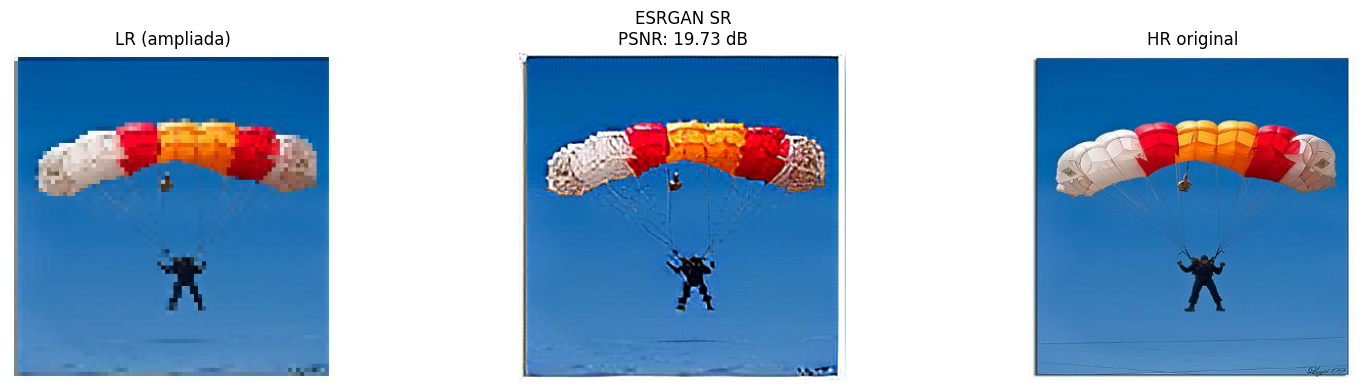

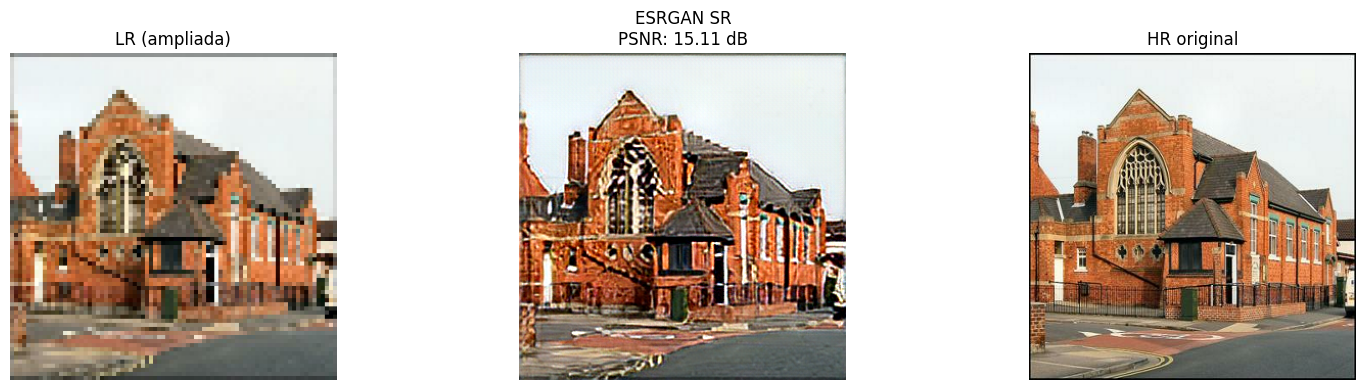

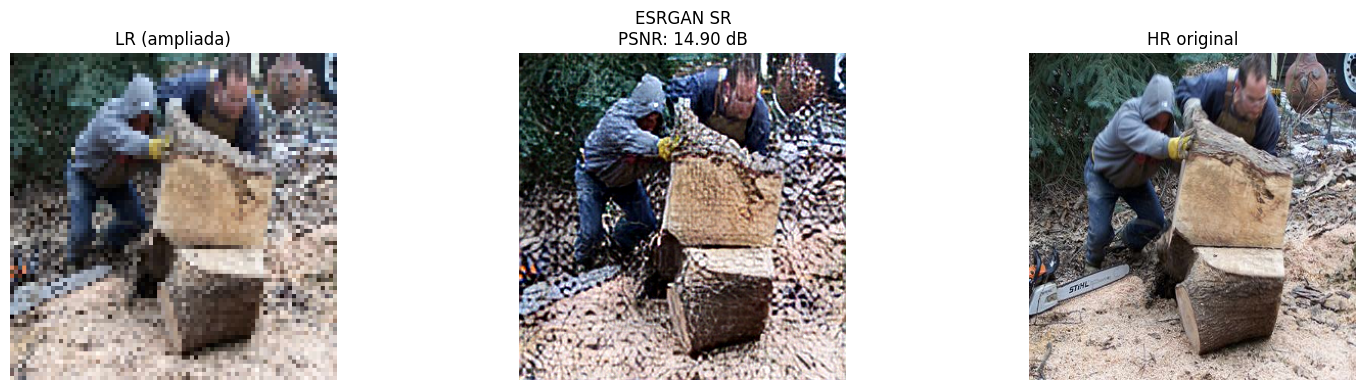

In [74]:
# Apliquem ESRGAN a les mateixes imatges d'exemple que fem servir amb el nostre model
sample_files = random.sample(test_files, 3)

# Per a cada imatge
for file in sample_files:
    # Preparar la imatge LR de test
    lr, hr = preprocess_image_for_sr(str(file))
    lr_esrgan = tf.expand_dims(lr * 255.0, axis=0)
    sr_esrgan_255 = esrgan(lr_esrgan)
    # Convertir sortida a [0,1] float
    sr_esrgan = tf.squeeze(sr_esrgan_255, axis=0) / 255.0
    sr_esrgan = tf.clip_by_value(sr_esrgan, 0.0, 1.0)
    # Calcular PSNR comparat amb HR
    psnr_esrgan = tf.image.psnr(sr_esrgan, hr, max_val=1.0).numpy()
    # Visualitzar comparativa
    lr_up = tf.image.resize(lr, [320, 320], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    lr_disp = (lr_up.numpy() * 255).astype(np.uint8)
    sr_disp = (sr_esrgan.numpy() * 255).astype(np.uint8)
    hr_disp = (hr.numpy() * 255).astype(np.uint8)
    
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(lr_disp)
    plt.title("LR (ampliada)")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(sr_disp)
    plt.title("ESRGAN SR\nPSNR: {:.2f} dB".format(psnr_esrgan))
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(hr_disp)
    plt.title("HR original")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong> Comentaris: </strong>
<ul>
    <li> <strong> Mètrica (PSNR) </strong>:Els valors al voltant de 15-20 dB amb una mitja de 19dB són acceptables però inferiors als de l'entrenament anterior, ja que aquell s'ha fet amb dades similars.  </li>
    <li> <strong> Qualitat visual </strong>: Les imatges generades amb ESRGAN semblen més nítides que les versions LR ampliades, però encara s'hi pot veure pèrdua de definició en zones complexes. </li>
    <li> <strong> Detalls </strong>: Es poden veure millor els contorns i les vores respecte al LR, tot i que en alguns casos (cabells, detalls petits, etc.) poden tindre defectes lleus. </li>
</ul>  
</div>

## 8. Comparació i conclusions (0,5 pts)

En aquesta pràctica hem explorat tant la classificació d’imatges amb xarxes neuronals (denses vs convolucionals) com la superresolució amb CNNs, aplicant-ho tot sobre la base de dades d’Imagenette.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;"> <strong> Exercici 8 [0,5 pts]: </strong> Fes un resum dels punts apresos en aquest PAC. Concretament, resumeix en una frase el que has après de cadascun dels punts enumerats a continuació: <ul>
    <li> <strong> ANN vs CNN: </strong> </li>
    <li> <strong> Regularització i augmentació: </strong> </li>
    <li> <strong> Superresolució: </strong> </li>
    <li> <strong> Transfer learning: </strong> </li>
</ul>
Valoració final
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong> Comentaris: </strong>
<br> <br>
Conclusions finals:
<ul>
    <li>
        <strong> ANN vs CNN: </strong> Les CNN són més eficients per a imatges ja que poden extreure característiques especials amb les convolucions.
    </li>
    <li>
        <strong> Regularització i augmentació: </strong> Existeixen tècniques com el Dropout, l'Early Stopping i l'Augmentació de dades que, aplicades correctament, ajuden a evitar el sobreajustament i milloren la capacitat de generalització del model.
    </li>
    <li>
        <strong> Superresolució: </strong> La superresolució consisteix a augmentar la resolució de la imatge partint d’una versió de baixa resolució i recuperant detalls.
    </li>
    <li>
        <strong> Transfer Learning: </strong> Aprofitar models pre-entrenats en grans conjunts de dades pot proporcionar resultats equivalents i accelear l'entrenament. En la meva feina acostumo a fer servir transfer learning i comprovat la seva eficiència amb projectes on les dades son limitades.
    </li>
</ul>


En aquesta PAC s'han pogut veure i probar diferents tècniques i arquitectures de Deep Learning, tant en classiciació com en superresolució, la importància de la regularització, l'augmentació i l'ús de models pre-entrenats, per millorar el rendiment i la generalització. 
<br> <br>
</div>